In [1]:
import os
os.chdir('/mnt/diploma/')

In [2]:
import random

import matplotlib.pyplot as plt
import numpy as np
import umap
from experiment_collection.experiments import Experiment, ExperimentCollectionRemote
from scipy.spatial import distance
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from tqdm.notebook import tqdm

from hse_dialog_tree.kmeans_names import get_names
from hse_dialog_tree.utils.cpu import get_processor_info
from hse_dialog_tree.utils.files import load_pickle, dump_pickle

LANG = 'rus'
print(get_processor_info())

 Intel(R) Core(TM) i5-7200U CPU @ 2.50GHz x 4


In [3]:
only_sentences = load_pickle(f'data/{LANG}/01_only_sentences.pkl.zip')
vectors = load_pickle(f'data/{LANG}/02_vectors_v2.pkl.zip')
exps = ExperimentCollectionRemote('https://experiments.asciishell.ru/', '03_kmeans')

Выполним поиск наиболее подходящего кластера путем перебора их количества.

Начальная подготовка необходима для упрощения распределенного вычисления.

In [4]:
queue = list(range(5, 100, 1))
random.shuffle(queue)
for cluster_num in tqdm(queue):
    exp = Experiment('kmeans_v2_{:03}'.format(cluster_num))
    if exps.check_experiment(exp):
        continue
    cluster_model_kmeans = MiniBatchKMeans(n_clusters=cluster_num, random_state=42, max_iter=500, batch_size=1000)
    clusters = cluster_model_kmeans.fit_predict(vectors)

    exp.set_params(cluster_model_kmeans.get_params())
    exp.set_metrics({
        'silhouette_score': silhouette_score(vectors, clusters),
        'davies_bouldin_score': davies_bouldin_score(vectors, clusters),
        'distortion_score': distance.cdist(vectors, cluster_model_kmeans.cluster_centers_, 'euclidean').min(axis=1).mean(),
        'inertia_score': cluster_model_kmeans.inertia_,
        })
    exps.add_experiment(exp, ignore_included=True)
    dump_pickle(cluster_model_kmeans, 'steps/03_kmeans/{}.pkl.zip'.format(exp.name))

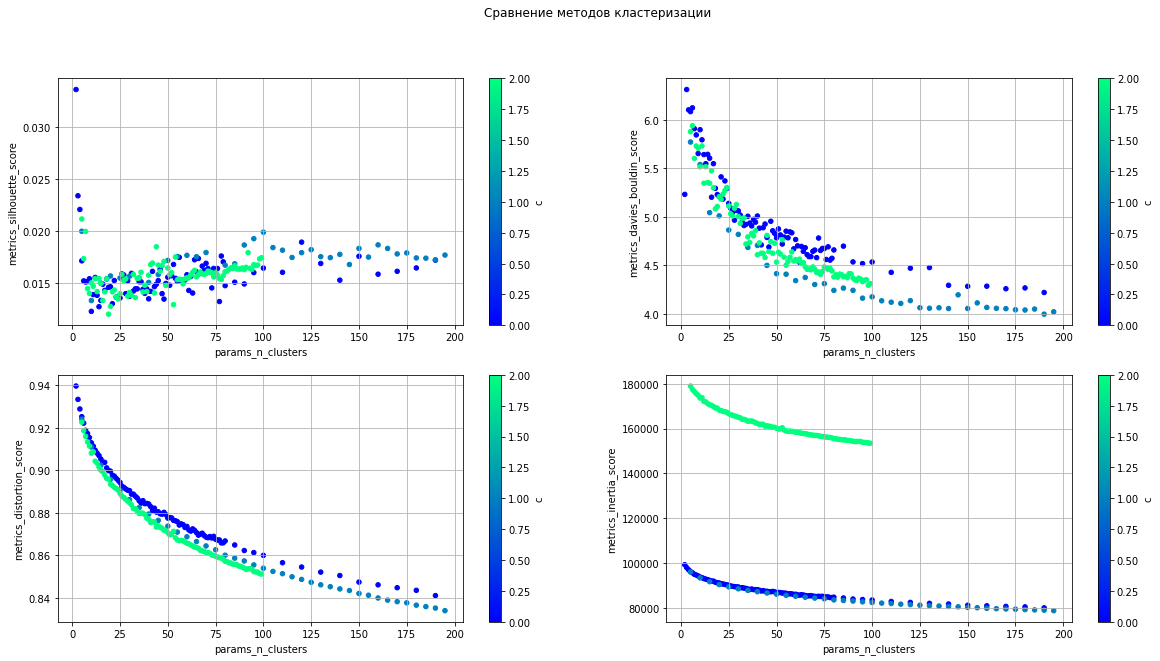

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), facecolor='w')
plt.suptitle('Сравнение методов кластеризации')
df = exps.get_experiments()
df['c'] = df['name'].str.count('full') + df['name'].str.count('kmeans_v2') * 2
df.plot.scatter(x='params_n_clusters', y='metrics_silhouette_score', c='c', colormap='winter', grid=True, ax=axes[0, 0])
df.plot.scatter(x='params_n_clusters', y='metrics_davies_bouldin_score', c='c', colormap='winter', grid=True, ax=axes[0, 1])
df.plot.scatter(x='params_n_clusters', y='metrics_distortion_score', c='c', colormap='winter', grid=True, ax=axes[1, 0])
df.plot.scatter(x='params_n_clusters', y='metrics_inertia_score', c='c', colormap='winter', grid=True, ax=axes[1, 1]);

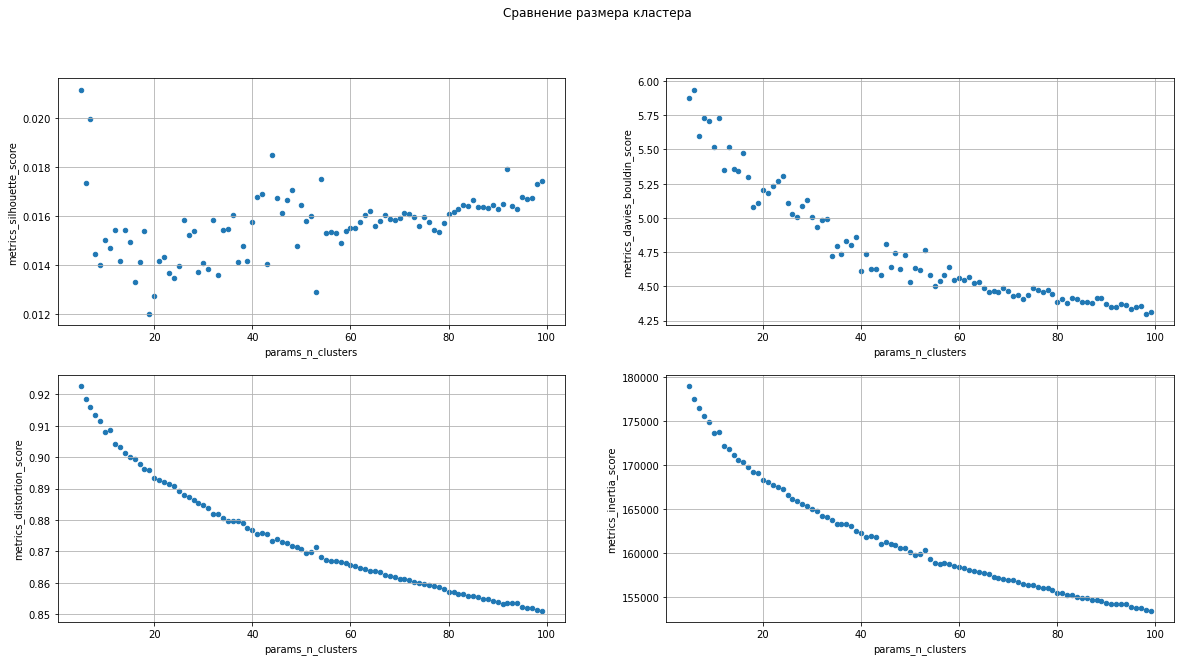

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10), facecolor='w')
plt.suptitle('Сравнение размера кластера')
df = exps.get_experiments()
df = df[df['name'].str.count('kmeans_v2') > 0].copy()
df.plot.scatter(x='params_n_clusters', y='metrics_silhouette_score', grid=True, ax=axes[0, 0])
df.plot.scatter(x='params_n_clusters', y='metrics_davies_bouldin_score', grid=True, ax=axes[0, 1])
df.plot.scatter(x='params_n_clusters', y='metrics_distortion_score', grid=True, ax=axes[1, 0])
df.plot.scatter(x='params_n_clusters', y='metrics_inertia_score', grid=True, ax=axes[1, 1]);

In [7]:
df[['name', 'metrics_silhouette_score']].sort_values('metrics_silhouette_score', ascending=False).head()

,name,metrics_silhouette_score
131,kmeans_v2_005,0.021158
133,kmeans_v2_007,0.019959
170,kmeans_v2_044,0.018483
218,kmeans_v2_092,0.017915
180,kmeans_v2_054,0.017494


In [8]:
cluster_model_kmeans = load_pickle('steps/03_kmeans/kmeans_v2_044.pkl.zip')

In [9]:
umap_vectors = umap.UMAP()
umap_vectors.fit(vectors[:100000])
umap_vectors_transformed = umap_vectors.transform(vectors)

In [10]:
clusters = cluster_model_kmeans.predict(vectors)

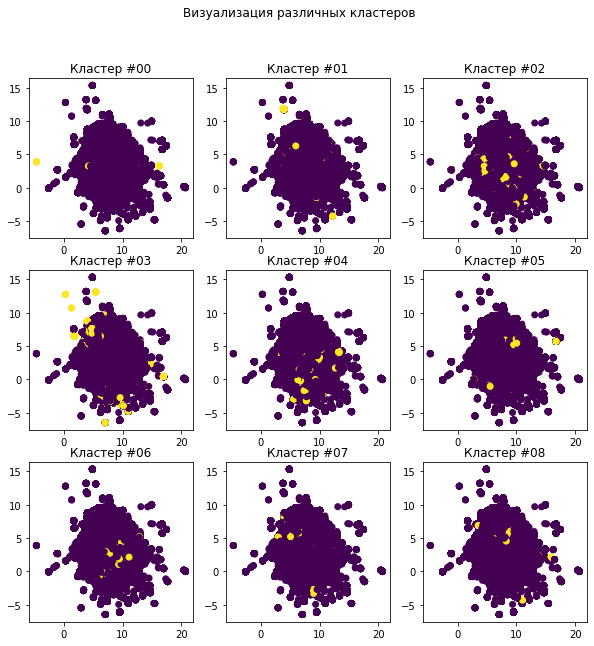

In [12]:
plt.figure(figsize=(10, 10), facecolor='w')
plt.suptitle('Визуализация различных кластеров')
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.scatter(umap_vectors_transformed[:,0], umap_vectors_transformed[:,1], c=clusters == i)
    plt.title('Кластер #{:02d}'.format(i))

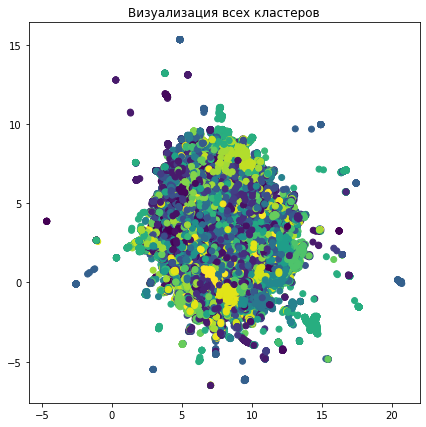

In [14]:
plt.figure(figsize=(7, 7), facecolor='w')
plt.title('Визуализация всех кластеров')
plt.scatter(umap_vectors_transformed[:,0], umap_vectors_transformed[:,1], c=clusters);

In [15]:
sents_with_clusters = list(zip(only_sentences, clusters))

In [16]:
cluster_names = get_names(cluster_model_kmeans)
assert cluster_names is not None

In [17]:
curr_cluster = 1
cluster_distance = distance.cdist([cluster_model_kmeans.cluster_centers_[curr_cluster]], vectors, 'euclidean')[0]
most_similar_index = np.argmin(cluster_distance)
sentences_in_cluster = [sent for sent, cluster in sents_with_clusters if cluster ==    curr_cluster]
print('Total: ', len(sentences_in_cluster))
print('Name: ', cluster_names[curr_cluster])
print('Best: ', only_sentences[most_similar_index], end='\n=============================\n')
print(*random.choices(sentences_in_cluster, k=20), sep='\n=============================\n')

Total:  4264
Name:  Короткая нейтральная фраза
Best:  Я пасс.
Что-то не хочется.
Поведи их в мою комнату.
Началось. О мой легкомысленный мэтр.
Это для меня чудно.
Ну вот и я пьисой!
Уж я так и доложу.
И слышать не хочет.
Я этому и рада.
Поздно меня учить, я уж учена.
И я люблю его сердечно.
Ну, встретились мы. Она меня звала к себе.
Так уж я буду надеяться.
Я? Да... пишу.
Да я не хочу.
Слушаю.
Душа моя, я тоже женщина.
Мы танцевать хотим!
Я выиграл его.
Мне душно от белых цветов!
Да чем я виновата?
